In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch

import os
# which folder
folder_index = 2
# Function to get the next available filename
def get_next_filename(base_name, extension):
    index = 1
    while True:
        filename = f"{base_name}_{index}.{extension}"
        if not os.path.exists(filename):
            return filename
        index += 1

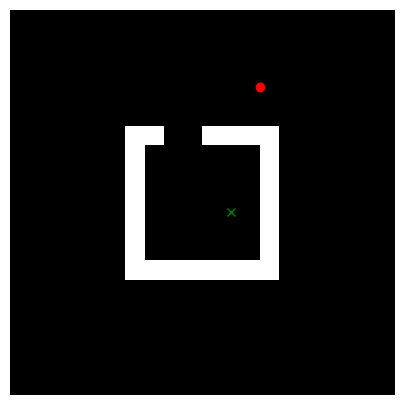

In [2]:
from grid_env import GridEnv
env = GridEnv(sparse=True)
env.plot()

The shape of the state pairs are: 
torch.Size([100000, 2, 2])
Example of a state pair: tensor([[ 5., 14.],
        [ 4.,  5.]])

The shape of the preferences are: 
torch.Size([100000, 1])
The preferences are: tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [1.]])


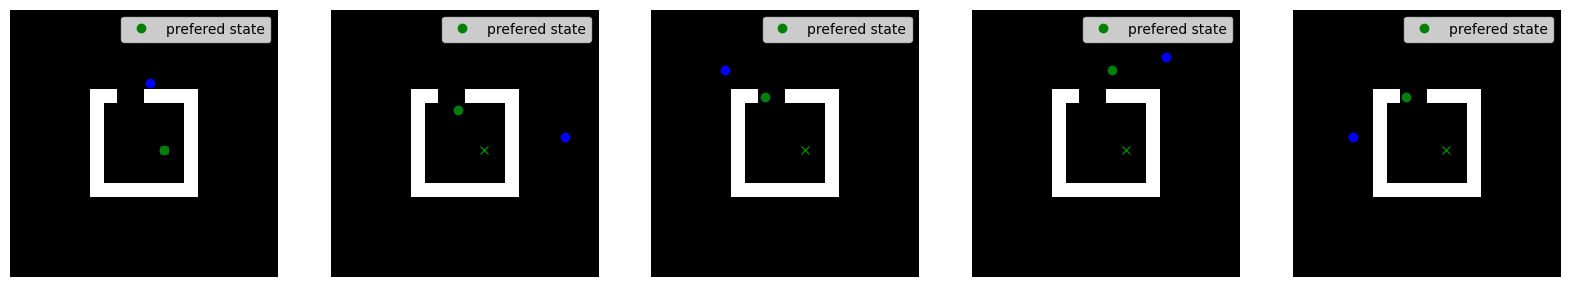

In [3]:
# load the state_pairs and preferences.pt
state_pairs = torch.load(f'world_{folder_index}/state_pairs.pt')
preferences = torch.load(f'world_{folder_index}/preferences.pt')

print("The shape of the state pairs are: \n" + str(state_pairs.size()))
print("Example of a state pair: " + str(state_pairs[0]))
print("")
print("The shape of the preferences are: \n" + str(preferences.size()))
print("The preferences are: " + str(preferences))

num_pairs = state_pairs.size()[0]
# select 5 random pairs of states, and colour the state that is prefered in green
num_plot = 5
# create subplots
fig, axs = plt.subplots(1, num_plot, figsize=(20,5))
# plot each state pair
for i in range(num_plot):
    # randomly choose a state pair
    idx = np.random.randint(num_pairs)
    s1 = state_pairs[idx,0,:]
    s2 = state_pairs[idx,1,:]
    p = preferences[idx,0]
    # plot the first state
    axs[i].imshow(env.occ_map.T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
    axs[i].plot(env.xl+0.5,env.yl+0.5,'gx') # goal location
    axs[i].plot(s1[0]+0.5,s1[1]+0.5,'bo')
    # plot the second state
    axs[i].plot(s2[0]+0.5,s2[1]+0.5,'bo')
    # plot the prefered state in green
    if p == 0:
        axs[i].plot(s1[0]+0.5,s1[1]+0.5,'go', label='prefered state')
    else:
        axs[i].plot(s2[0]+0.5,s2[1]+0.5,'go', label='prefered state')
    # finish up the rest of the plot settings
    axs[i].legend()
    axs[i].axis('off')

In [4]:
# create dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class PreferenceDataset(Dataset):
    def __init__(self, state_pairs, preferences):
        self.state_pairs = state_pairs
        self.preferences = preferences

    def __getitem__(self, index):
        return self.state_pairs[index], self.preferences[index]

    def __len__(self):
        return len(self.state_pairs)

In [5]:
dataset = PreferenceDataset(state_pairs, preferences)
# split the dataset into train, validation and test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
# create dataloaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# print the shapes of batches from dataloaders
batch = next(iter(train_loader))
print("The shape of the input batch: " + str(batch[0].shape))
print("The shape of the batch labels: " + str(batch[1].shape))

The shape of the input batch: torch.Size([32, 2, 2])
The shape of the batch labels: torch.Size([32, 1])


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

# create a preference learning model
class PreferenceModel(nn.Module):
    def __init__(self):
        super(PreferenceModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 1),
        )
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # apply the linear layers to each state in the state pair
        #print(x[:,0].shape)
        x1 = self.fc(x[:, 0])
        x1 = torch.exp(x1)
        t_left_1 = x1[:, 0].unsqueeze(1)
        x2 = self.fc(x[:, 1])
        x2 = torch.exp(x2)
        t_left_2 = x2[:, 0].unsqueeze(1)
        return self.sigmoid(t_left_1 - t_left_2)
    
    def predict_time_to_goal(self, x):
        t = self.fc(x)
        t = torch.exp(t)
        t = t[:, 0].unsqueeze(1)
        return t
    
# training step
def training_step(input_batch, target_batch, model, optimizer, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    optimizer.zero_grad() # clear gradients in the optimiser
    loss.backward() # back prop
    optimizer.step() # gradient descend
    return loss.item() # return loss

# validation step
def validation_step(input_batch, target_batch, model, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    return loss.item()

In [7]:
# instantiate
model = PreferenceModel()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def loss_fn(preds, target):
    return F.binary_cross_entropy(preds, target)

num_epochs = 100

In [8]:
base_filename = f'world_{folder_index}/models/best_model'
file_extension = 'pt'
next_filename = get_next_filename(base_filename, file_extension)

# train
train_losses = []
val_losses = []
min_val_loss = float('inf')
early_stop_counter = 0
patience = 20

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # training
    model.train()
    for input_batch, target_batch in train_loader:
        train_loss += training_step(input_batch, target_batch, model, optimizer, loss_fn)
    # validation
    model.eval()
    for input_batch, target_batch in val_loader:
        val_loss += validation_step(input_batch, target_batch, model, loss_fn)
        
    # normalise the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Check if validation loss has decreased
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        # Save the model state
        torch.save(model.state_dict(), next_filename)
        # clear early stop counter
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # append the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # print the losses every 10 epoch
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch: 1/100, Train Loss: 0.6917, Val Loss: 0.6902
Epoch: 2/100, Train Loss: 0.6855, Val Loss: 0.6717
Epoch: 3/100, Train Loss: 0.4974, Val Loss: 0.2907
Epoch: 4/100, Train Loss: 0.2792, Val Loss: 0.2450
Epoch: 5/100, Train Loss: 0.2480, Val Loss: 0.2794
Epoch: 6/100, Train Loss: 0.2261, Val Loss: 0.2087
Epoch: 7/100, Train Loss: 0.2170, Val Loss: 0.1977
Epoch: 8/100, Train Loss: 0.2124, Val Loss: 0.2016
Epoch: 9/100, Train Loss: 0.2049, Val Loss: 0.1962
Epoch: 10/100, Train Loss: 0.2011, Val Loss: 0.1901
Epoch: 11/100, Train Loss: 0.2004, Val Loss: 0.2032
Epoch: 12/100, Train Loss: 0.1986, Val Loss: 0.1947
Epoch: 13/100, Train Loss: 0.1949, Val Loss: 0.2059
Epoch: 14/100, Train Loss: 0.1928, Val Loss: 0.1921
Epoch: 15/100, Train Loss: 0.1895, Val Loss: 0.1855
Epoch: 16/100, Train Loss: 0.1901, Val Loss: 0.1826
Epoch: 17/100, Train Loss: 0.1837, Val Loss: 0.1888
Epoch: 18/100, Train Loss: 0.1840, Val Loss: 0.1747
Epoch: 19/100, Train Loss: 0.1812, Val Loss: 0.1928
Epoch: 20/100, Train 

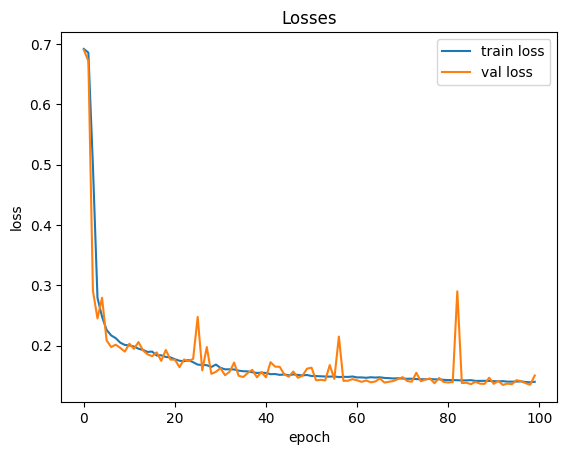

In [9]:
base_filename = f'world_{folder_index}/figs/loss'
file_extension = 'png'
next_filename = get_next_filename(base_filename, file_extension)

# plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')  
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()
plt.savefig(next_filename)
plt.show()

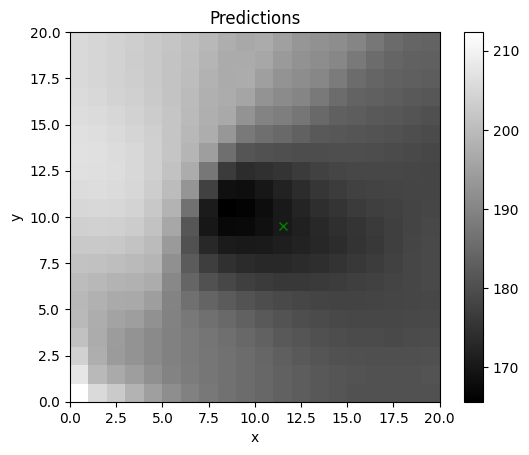

In [10]:
# plot the predictions over a 2D grid 
def plot_predictions(model, env):
    # create a 2D grid
    x = np.linspace(0, env.N-1, env.N)
    y = np.linspace(0, env.N-1, env.N)
    X, Y = np.meshgrid(x, y)
    
    # create a tensor of the grid
    grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float)
    # get the predictions
    preds = model.predict_time_to_goal(grid).detach().numpy()
    #print(preds)
    # reshape the predictions
    preds = preds.reshape(env.N, env.N)
    # plot the predictions
    plt.imshow(preds.T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
    plt.colorbar()
    plt.plot(env.xl+0.5,env.yl+0.5,'gx') # goal location
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predictions')
    plt.show()

plot_predictions(model, env)

In [ ]:
# test value iteration on the grid
